신경망 학습
========
학습을 해보자! 학습을 하려면, 제일 먼저 지금 학습이 얼마나 잘 되었는지를 수치로 평가해주는 **손실 함수**<small>loss function</small>가 필요하다. 많이 쓰이는 손실 함수 두개를 직접 구현해보자.

수식은 [codecogs의 수식편집기](https://www.codecogs.com/latex/eqneditor.php)를 써서 작성하였다.

### 평균 제곱 오차 <small>Mean squared error, MSE</small>
$${\displaystyle 
{\rm MSE}(y, t) = \frac1n \sum_k^n (y_k - t_k)^2
}$$

In [49]:
import numpy as np

def mean_squared_error(expected, actual):
    return ((expected - actual)**2).mean(axis=0)

expected = np.array((0.08, 0.87, 0.05))
actual = np.array((0, 1, 0))
print(f'정확도가 높은 경우 : {mean_squared_error(expected, actual)}')

expected = np.array((0.08, 0.87, 0.05))
actual = np.array((0, 0, 1))
print(f'정확도가 낮은 경우 : {mean_squared_error(expected, actual)}')

정확도가 높은 경우 : 0.008600000000000002
정확도가 낮은 경우 : 0.5552666666666667


### 교차 엔트로피 오차 <small>Cross entropy error, CEE</small>
$${\displaystyle 
{\rm CEE}(y, t) = - \sum_k t_k {\rm log}_2 y_k
}$$

In [50]:
def cross_entropy_error(expected, actual):
    epsilon = 1E-7
    return -(actual * np.log(expected + epsilon)).sum(axis=0)


expected = np.array((0.08, 0.87, 0.05))
actual = np.array((0, 1, 0))
print(f'정확도가 높은 경우 : {cross_entropy_error(expected, actual)}')

expected = np.array((0.08, 0.87, 0.05))
actual = np.array((0, 0, 1))
print(f'정확도가 낮은 경우 : {cross_entropy_error(expected, actual)}')

정확도가 높은 경우 : 0.13926195239098557
정확도가 낮은 경우 : 2.9957302735559908


### 미니배치 학습
교차 엔트로피 오차 수식을 살짝만 바꿔서, 미니배치용 손실함수를 만들어서 쓰면 된다.

$${\displaystyle 
{\rm CEE}(y, t) = - \frac1N \sum_i^N \sum_k t_{ik} {\rm log}_2 y_{ik}
}$$

In [56]:
# Cross entropy error function for batch input
def cross_entropy_error(expected, actual):
    if expected.ndim == 1:
        expected = expected.reshape(1, expected.size)
        actual = actual.reshape(1, actual.size)
    
    batch_size = expected.shape[0]
    return -np.sum(actual * np.log(expected), axis=0) / batch_size

# 3개 입력에 대한 손실함수를 한번에 계산함
expected_batch = np.array([
    (0.08, 0.87, 0.05),
    (0.89, 0.06, 0.05),
    (0.04, 0.12, 0.84),
])
actual_batch = np.array([
    (0, 1, 0),
    (1, 0, 0),
    (0, 0, 1),
])
print(f'손실율 : {cross_entropy_error(expected_batch, actual_batch)}')

손실율 : [ 0.03884461  0.04642069  0.0581178 ]


### 수치 미분 <small>Numerical differentiation</small>
중앙 차분법을 쓸것이다.

$${\displaystyle 
f'(x) \simeq \frac{f(x+h) - f(x-h)}{2h} \text{ where } h \text{ is small enough}
}$$

In [4]:
def derivate(f, h=1E-4):
    """
    미분 연산자. 이 함수의 파라미터로 미분하고싶은 함수를 넘기면, 도함수가 결과로 나온다.

    .. code-block:: python

       linear = lambda x: x**2 + 2*x + 1
       deriv = derivate(linear)

       deriv(0) # 2
       deriv(2) # 6
    """
    return lambda x: (f(x+h) - f(x-h))/(2*h)

func = lambda x: 0.01 * x**2 + 0.1 * x
deriv = derivate(func)
deriv_analytic = lambda x: 0.02 * x + 0.1

for x in 5, 10, 15:
    print(f'해석적 미분 : {deriv_analytic(x)}')
    print(f'수치 미분   : {deriv(x)}')
    print()

해석적 미분 : 0.2
수치 미분   : 0.1999999999990898

해석적 미분 : 0.30000000000000004
수치 미분   : 0.2999999999986347

해석적 미분 : 0.4
수치 미분   : 0.4000000000026205



### 편미분
걍 하면 된다

$${\displaystyle 
\begin{align}
\frac{\partial f}{\partial x_i}(a_1,\ldots,a_n) \simeq & \frac{f(a_1,\ldots,a_i+h,\ldots,a_n) - f(a_1,\ldots, a_i-h, \dots,a_n)}{2h}
\\ & \text{ where } h \text{ is small enough}
\end{align}
}$$

In [5]:
def partial_derivate(f, nth, h=1E-4):
    """
    편미분 연산자.

    이 함수의 파라미터로 편미분하고싶은 함수와, 몇번째 파라미터를 기준으로 편미분할지 
    전달하면, 편도함수가 결과로 나온다.

    .. code-block:: python

       surface = lambda a, b: a**2 + b**2
       partial = partial_derivate(surface, 0)

       partial(1, 2) # 2
       partial(2, 3) # 4
    """
    def func(*args):
        param1, param2 = list(args), list(args)
        param1[nth] += h
        param2[nth] -= h
        return (f(*param1) - f(*param2))/(2*h)
    return func

func = lambda a, b, c: a**2 + b**2 + c**2
partial = partial_derivate(func, 0)
partial_analytic = lambda a, b, c: 2*a

for args in (1, 2, 3), (4, 5, 6), (7, 8, 9):
    print(f'해석적 편미분 : {partial_analytic(*args)}')
    print(f'수치 편미분   : {partial(*args)}')
    print()

해석적 편미분 : 2
수치 편미분   : 1.9999999999953388

해석적 편미분 : 8
수치 편미분   : 8.00000000005241

해석적 편미분 : 14
수치 편미분   : 13.999999999896318



하지만 우리가 이를 제대로 활용하려면, 다인자 함수이더라도 입력을 하나의 numpy 배열로 받는 함수로 만들어야한다. 이하는 `partial_derivate` 함수의 numpy 버전이다.

In [79]:
def partial_derivate(f, nth, h=1E-4):
    """
    편미분 연산자.

    이 함수의 파라미터로 편미분하고싶은 함수와, 몇번째 파라미터를 기준으로 편미분할지 
    전달하면, 편도함수가 결과로 나온다.

    .. code-block:: python

       surface = lambda args: (args**2).sum(axis=0)
       partial = partial_derivate(surface, 0)

       partial(np.array([1, 2])) # 2
       partial(np.array([2, 3])) # 4
    """
    def func(args):
        param1 = args.astype(float)
        param2 = param1.copy()
        param1[nth] += h
        param2[nth] -= h
        return (f(param1) - f(param2))/(2*h)
    return func

func = lambda args: (args**2).sum(axis=0)
partial = partial_derivate(func, 0)
partial_analytic = lambda args: 2*args[0]

for args in (1, 2, 3), (4, 5, 6), (7, 8, 9):
    param = np.array(args)
    print(f'해석적 편미분 : {partial_analytic(param)}')
    print(f'수치 편미분   : {partial(param)}')
    print()

해석적 편미분 : 2
수치 편미분   : 1.9999999999953388

해석적 편미분 : 8
수치 편미분   : 8.00000000005241

해석적 편미분 : 14
수치 편미분   : 13.999999999896318



### 그래디언트 <small>Gradient</small>
각 성분에 대한 편미분으로 구성된 열벡터이다.

$${\displaystyle
\nabla f=\left({\frac {\partial f}{\partial x_{1}}},\dots ,{\frac {\partial f}{\partial x_{n}}}\right)
}$$

In [94]:
import inspect

def grad(f, h=1E-4):
    """
    델(∇) 연산자. nabla 연산자의 인자로 스칼라 함수를 넣으면, 그 함수의 그래디언트가 반환된다.
    
    .. code-block:: python
    
       surface = lambda a, b: a**2 + b**2
       gradient = grad(surface)
       
       gradient(np.array([1, 2])) # array([2, 4])
       gradient(np.array([2, 3])) # array([4, 6])
    """
    def func(args):
        if func.components is None:
            func.components = [partial_derivate(f, i) for i in range(args.shape[-1])]
        return np.fromiter((component(args) for component in func.components), float)
    func.components = None
    return func
    
func = lambda args: (args**2).sum(axis=0)
gradient = grad(func)
gradient_analytic = lambda args: 2*args

for args in (1, 2, 3), (4, 5, 6), (7, 8, 9):
    param = np.array(args)
    print(f'해석적 그래디언트 : {gradient_analytic(param)}')
    print(f'수치 그래디언트   : {gradient(param)}')
    print()

해석적 그래디언트 : [2 4 6]
수치 그래디언트   : [ 2.  4.  6.]

해석적 그래디언트 : [ 8 10 12]
수치 그래디언트   : [  8.  10.  12.]

해석적 그래디언트 : [14 16 18]
수치 그래디언트   : [ 14.  16.  18.]



### 경사법 <small>Gradient method</small>
기울기가 얕아지는쪽으로 계속 이동하여, local minima/maxima를 찾아보자.

$${\displaystyle
x' = x - \eta \nabla f (x) \\
}$$

저기서 $f$를 목적함수<small>Objective function</small>라고 부르며, $\eta$는 학습률<small>Learning rate</small>이라고 부른다.

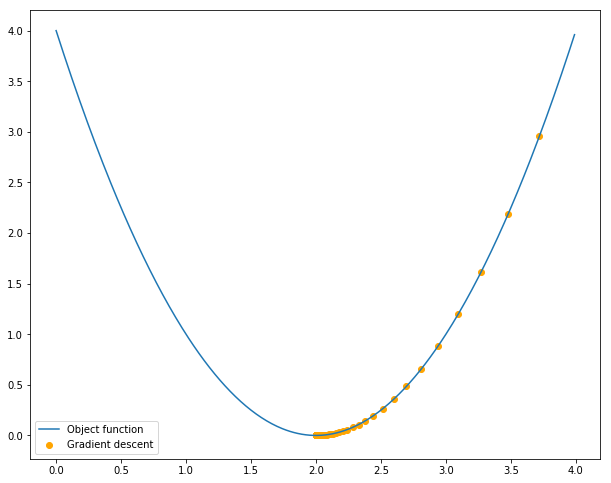

In [153]:
import matplotlib.pyplot as plt

def grad_descent(f, x=4, eta=0.07, iteration=100):
    gradient = grad(f)
    results = np.empty((iteration, 2))
    for i in range(iteration):
        x = x - eta * gradient(np.array([x]))
        y = func(x)
        results[i,0] = x
        results[i,1] = f(x)
    return results[-1], results

func = lambda x: (x-2)**2
result, process = grad_descent(func)

plt.figure(1, figsize=(9,7)).subplots_adjust(left=0.10, bottom=0.09, top=0.98, right=0.98)
x = x = np.arange(0, 4, 0.01)
y = func(x)
plt.plot(x, y, label='Object function')

plt.scatter(process[...,0], process[...,1], color='orange', label='Gradient descent')

plt.legend()
plt.show()

In [ ]:
# TODO
import mnist

# Load training images
MNIST = mnist.load()
train_img = MNIST['train_img']
train_label = MNIST['train_label']

# Randomly sample 10 images from the training set
batch_size = 10
subset = np.random.choice(train_img.shape[0], batch_size)
batch_img = train_img[subset]
batch_label = train_label[subset]